In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt

import shap

from utils import plot_pca

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor


In [5]:
# load data
df = pd.read_csv('../data/EDD_isoprenol_production.csv', index_col=0)
df.drop('Measurement Type', axis=1, inplace=True)

# Split the data into X and y
X = df.drop('Value', axis=1).copy()
X = X.astype('int64')
y = df['Value'].copy()

df.head(3)

,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
Line Name,,,,,,,,,
Strain 1,0.000000,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0
Strain 2,0.552101,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0
Strain 3,0.349196,1.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0


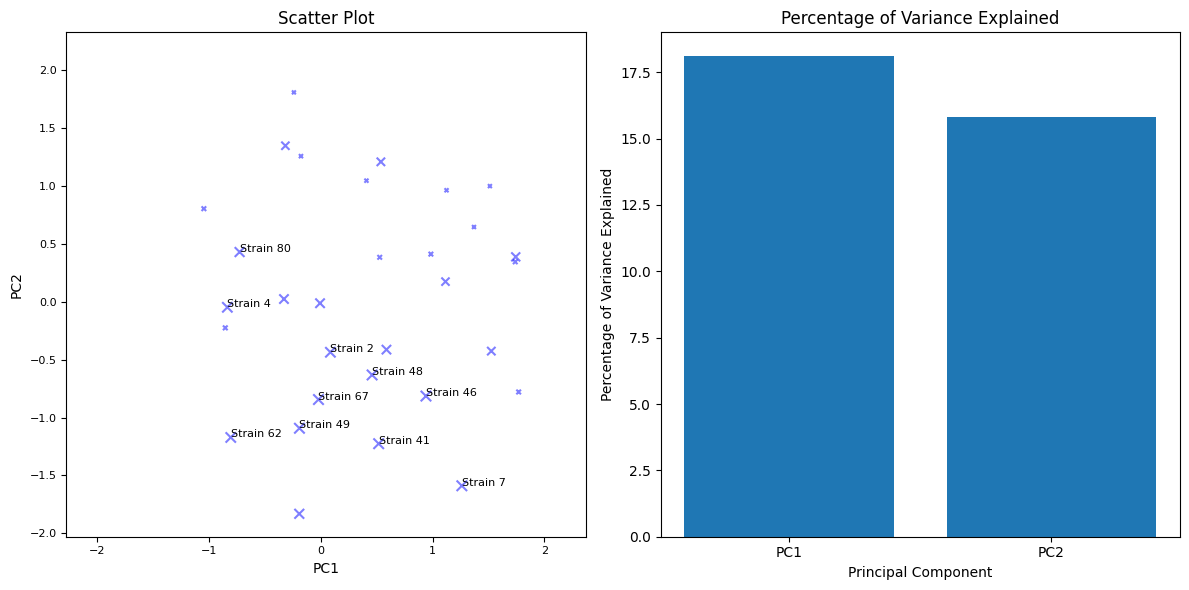

In [6]:
# Perfrom PCA on the data
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(df.drop('Value', axis=1)), index=df.index, columns=['PC1', 'PC2'])
pca_df.index = df.index
pca_df['Value'] = df['Value']

# Plot the PCA
plot_pca(pca_df, pca)

RMSE = 0.0296
STD = 0.0008


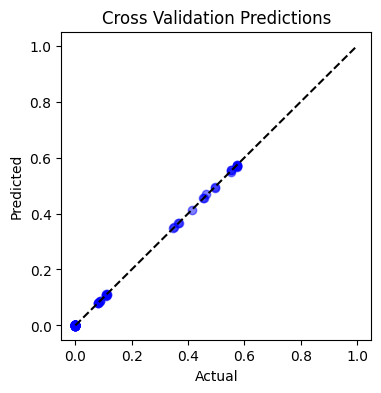

In [7]:
# Cross validate a Linear Regression model on the data
def train(model, X, y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10)
    print(f'RMSE = {np.round(np.sqrt(np.abs(scores.mean())),4)}')
    print(f'STD = {np.round(scores.std(),4)}')
    model.fit(X, y)
    return model

def plot_R2(model, X, y):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(y, model.predict(X), color='blue', alpha=0.5)
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title('Cross Validation Predictions')
    plt.show()

xgb = train(XGBRegressor(), X, y)
plot_R2(xgb, X, y)

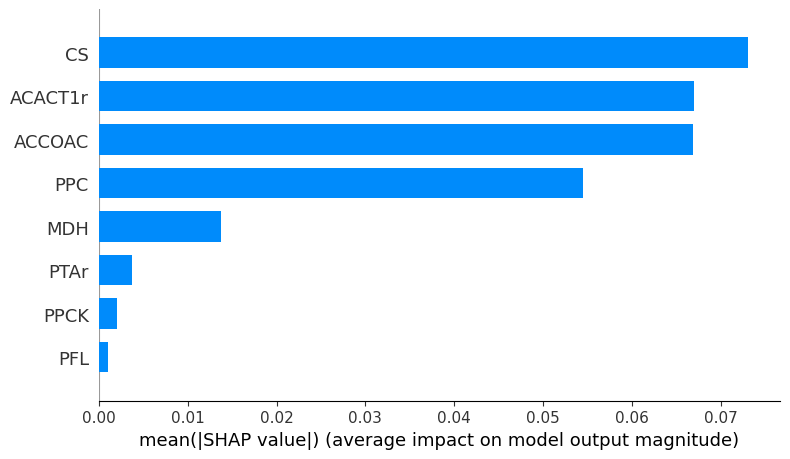

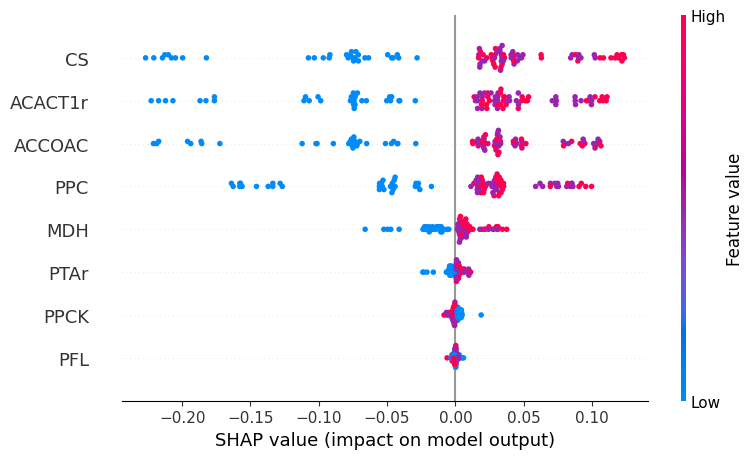

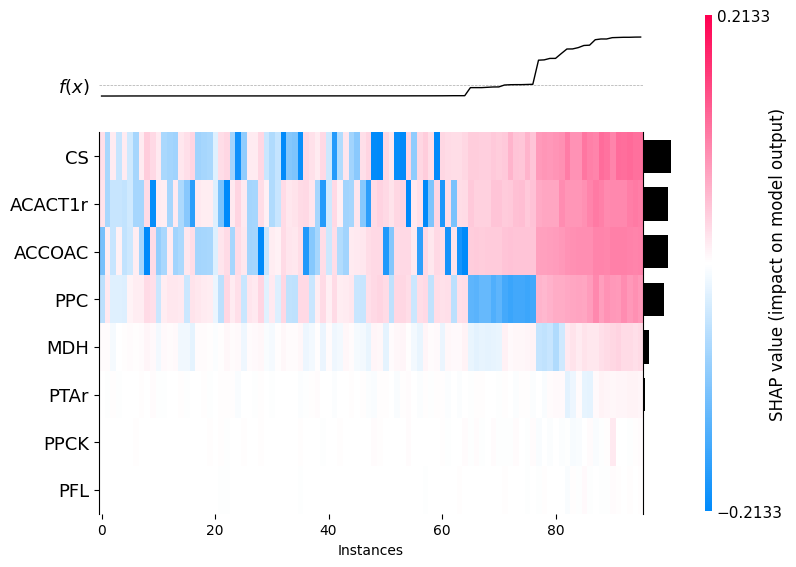

In [8]:
def shap_plots(model, X):
    # Calculate SHAP values and plot
    explainer = shap.TreeExplainer(model, X)
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, plot_type='bar')
    shap.summary_plot(shap_values, X, plot_type='dot')
    order = np.argsort(model.predict(X))
    shap.plots.heatmap(shap_values, instance_order=order)
    return explainer, shap_values

explainer, shap_values = shap_plots(xgb, X)

## PDP & ICE

In [16]:
# Create mapping for the df columns
mapping = pd.DataFrame(columns=['Feature', 'index'])
mapping['Feature'] = X.columns
mapping['index'] = [i for i in range(len(X.columns))]
mapping

,Feature,index
0,ACCOAC,0
1,MDH,1
2,PTAr,2
3,CS,3
4,ACACT1r,4
5,PPC,5
6,PPCK,6
7,PFL,7


In [22]:
mapping[mapping['Feature'] == 'CS']['index'].values[0]

3

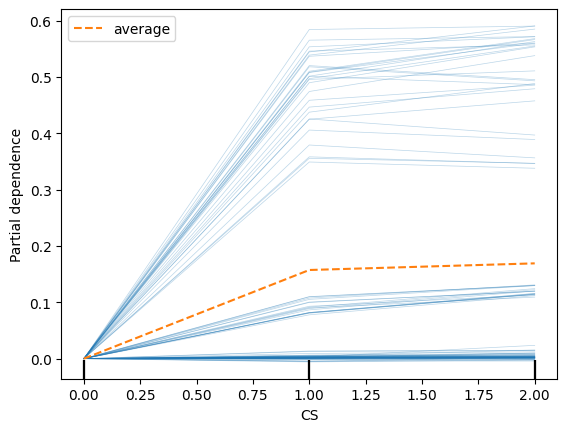

In [24]:
from sklearn.inspection import PartialDependenceDisplay

col = 'CS'
idx = mapping[mapping['Feature'] == col]['index'].values[0]
PartialDependenceDisplay.from_estimator(xgb, X, [idx], kind='both', centered=True)
plt.show()

In [ ]:
# from interpret import set_visualize_provider, show
# from interpret.blackbox import PartialDependence
# from interpret.provider import InlineProvider
# set_visualize_provider(InlineProvider())

# pdp = PartialDependence(rf, X)
# show(pdp.explain_global(), 0)

## LIME

In [11]:
import lime
import lime.lime_tabular

In [12]:
categorical_features = [i for i in range(len(X.columns))]
explainer = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names=X.columns.values.tolist(),
                                                  verbose=True, mode='regression',  
                                                   categorical_features=categorical_features)
j = 1
exp = explainer.explain_instance(X.values[j], xgb.predict, num_features=8)
exp.show_in_notebook(show_table=True, show_all=True)
pd.DataFrame(exp.as_list(), columns=['Feature', 'Contribution'])

Intercept -0.007579215886429583
Prediction_local [0.344249]
Right: 0.55412656


,Feature,Contribution
0,ACCOAC=1,0.092784
1,CS=2,0.090863
2,ACACT1r=2,0.085346
3,PPC=1,0.057716
4,MDH=2,0.018693
5,PTAr=2,0.011219
6,PPCK=1,-0.004961
7,PFL=0,0.000169


## OMLT

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # suppress CUDA warnings from tensorflow

# import the necessary packages
from omlt import OmltBlock, OffsetScaling
from omlt.io.keras import load_keras_sequential
from omlt.neuralnet import ReluBigMFormulation
import pyomo.environ as pyo
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv('../data/EDD_isoprenol_production.csv', index_col=0)
df.drop('Measurement Type', axis=1, inplace=True)
X = df.drop('Value', axis=1).copy()
y = df['Value'].copy()

In [ ]:
inputs = X.columns.values.tolist()
outputs = ['Value']

dfin = df[inputs]
dfout = df[outputs]

In [ ]:
# We scale the data for improved training, however, we want to formulate
# our optimizaton problem on the original variables. Therefore, we keep
# the scaling parameters to use later in our optimization formulation

x_offset, x_factor = dfin.mean().to_dict(), dfin.std().to_dict()
y_offset, y_factor = dfout.mean().to_dict(), dfout.std().to_dict()

dfin = (dfin - dfin.mean()).divide(dfin.std())
dfout = (dfout - dfout.mean()).divide(dfout.std())

# capture the minimum and maximum values of the scaled inputs
# so we don't use the model outside the valid range
scaled_lb = dfin.min()[inputs].values
scaled_ub = dfin.max()[inputs].values

In [ ]:
# create our Keras Sequential model
nn = Sequential(name='reformer_relu_4_20')
nn.add(Dense(units=50, input_dim=len(inputs), activation='relu'))
# nn.add(Dense(units=248, activation='relu'))
# nn.add(Dense(units=10, activation='relu'))
# nn.add(Dense(units=10, activation='relu'))
nn.add(Dense(units=len(outputs)))
nn.compile(optimizer=Adam(), loss='mse')

In [ ]:
X = dfin.values
y = dfout.values

history = nn.fit(X, y, epochs=100, validation_split=0.2, verbose=0)

In [ ]:
# Plot the loss function over time
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# first, create the Pyomo model
m = pyo.ConcreteModel()
# create the OmltBlock to hold the neural network model
m.reformer = OmltBlock()

# load the Keras model
# nn_reformer = keras.models.load_model('reformer_nn_relu', compile=False)
nn_reformer = nn

# Note: The neural network is in the scaled space. We want access to the
# variables in the unscaled space. Therefore, we need to tell OMLT about the
# scaling factors
scaler = OffsetScaling(
        offset_inputs={i: x_offset[inputs[i]] for i in range(len(inputs))},
        factor_inputs={i: x_factor[inputs[i]] for i in range(len(inputs))},
        offset_outputs={i: y_offset[outputs[i]] for i in range(len(outputs))},
        factor_outputs={i: y_factor[outputs[i]] for i in range(len(outputs))}
    )

scaled_input_bounds = {i: (scaled_lb[i], scaled_ub[i]) for i in range(len(inputs))}

# create a network definition from the Keras model
net = load_keras_sequential(nn_reformer, scaling_object=scaler, scaled_input_bounds=scaled_input_bounds)

# create the variables and constraints for the neural network in Pyomo
m.reformer.build_formulation(ReluBigMFormulation(net))

In [ ]:
# add the objective and constraints
iso_idx = outputs.index('Value')
m.obj = pyo.Objective(expr=m.reformer.outputs[iso_idx], sense=pyo.maximize)

In [ ]:
# now solve the optimization problem (this may take some time)
solver = pyo.SolverFactory('gurobi')
status = solver.solve(m, tee=False)

In [ ]:
for i in range(len(inputs)):
    print(inputs[i], np.round(pyo.value(m.reformer.inputs[i])))

for i in range(len(outputs)):
    print('***')
    print(outputs[i], pyo.value(m.reformer.outputs[i]))